In [181]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import os
import math
import numpy as np
import pandas as pd
import pickle
import re
from time import time
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC, OneClassSVM
import statsmodels as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sb

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel, LabelSet
from bokeh.transform import factor_cmap, jitter
from bokeh.palettes import Paired12, Spectral6, Viridis3

#Display bokeh graphis in a notebook
output_notebook()

Loading BokehJS ...

#### Load collision data

In [215]:
collision = pd.read_csv("../data/raw/collisions.csv")

In [216]:
collision.columns = collision.columns.str.lower()

In [217]:
collision.columns

Index(['x', 'y', 'objectid', 'inckey', 'coldetkey', 'reportno', 'status',
       'addrtype', 'intkey', 'location', 'exceptrsncode', 'exceptrsndesc',
       'severitycode', 'severitydesc', 'collisiontype', 'personcount',
       'pedcount', 'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries',
       'fatalities', 'incdate', 'incdttm', 'junctiontype', 'sdot_colcode',
       'sdot_coldesc', 'inattentionind', 'underinfl', 'weather', 'roadcond',
       'lightcond', 'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode',
       'st_coldesc', 'seglanekey', 'crosswalkkey', 'hitparkedcar'],
      dtype='object')

In [ ]:
#### Select interesting columns

In [218]:
col = ['x', 'y', 'status', \
       'addrtype', \
       'severitycode', 'severitydesc', 'collisiontype', 'personcount',
       'pedcount', 'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries',
       'fatalities', 'incdate', 'incdttm', 'junctiontype', 'sdot_colcode',
       'sdot_coldesc', 'inattentionind', 'underinfl', 'weather', 'roadcond',
       'lightcond', 'speeding', 'st_colcode',
       'st_coldesc', 'seglanekey', 'crosswalkkey', 'hitparkedcar']

In [219]:
collision_df = collision[col]

#### Rename x, y to long and lat

In [220]:
collision_df = collision_df.rename(columns = {"x": "long", "y": "lat"})

## Clean data

In [221]:
collision_df.shape

(221266, 30)

#### Find missing values in each column.

In [222]:
collision_df.isnull().sum()

long                 7469
lat                  7469
status                  0
addrtype             3712
severitycode            1
severitydesc            0
collisiontype       26499
personcount             0
pedcount                0
pedcylcount             0
vehcount                0
injuries                0
seriousinjuries         0
fatalities              0
incdate                 0
incdttm                 0
junctiontype        11967
sdot_colcode            1
sdot_coldesc            1
inattentionind     191078
underinfl           26479
weather             26688
roadcond            26608
lightcond           26776
speeding           211353
st_colcode           9413
st_coldesc          26499
seglanekey              0
crosswalkkey            0
hitparkedcar            0
dtype: int64

Fill in NA for inattention and speeding column with "N" - too many missing values 191k and 211k respectively.
Problem seems to be anomaly detection(needle in a haystack)

In [224]:
collision_df["speeding"].fillna("N", inplace = True)
collision_df["inattentionind"].fillna("N", inplace = True)

In [237]:
collision_df["speeding"].replace("Y", "1", inplace = True)
collision_df["speeding"].replace("N", "0", inplace = True)
collision_df["speeding"] = collision_df["speeding"].astype(int)

collision_df["inattentionind"].replace("Y", "1", inplace = True)
collision_df["inattentionind"].replace("N", "0", inplace = True)
collision_df["inattentionind"] = collision_df["inattentionind"].astype(int)

collision_df = collision_df.drop(columns = ["inattentionind"], axis = 1)

In [ ]:
#### Drop remaining missing values

In [239]:
collision_df.dropna(inplace = True)

In [240]:
collision_df.shape

(184934, 30)

## Plot univariate graphs

In [ ]:
#### Plot addrtype distribution

In [59]:
collision_addr_dist_df = collision_df.groupby(["addrtype"]).size().reset_index(name = "count")
collision_addr_dist_df = collision_addr_dist_df.sort_values("count", ascending = False)

In [72]:
block_perc =collision_addr_dist_df[collision_addr_dist_df["addrtype"] == "Block"]["count"]/float(collision_addr_dist_df["count"].sum())
print("{}% of accidents happen away from he intersection" .format(np.round(block_perc * 100, 1)))

1    66.6
Name: count, dtype: float64% of accidents happen away from he intersection


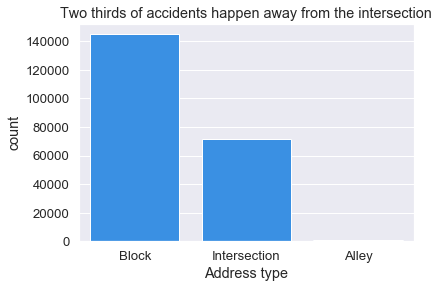

In [79]:
sb.set(font_scale = 1.2)
sb.barplot(x = "addrtype", y = "count", color = "dodgerblue", \
           data = collision_addr_dist_df)
plt.xlabel("Address type")
plt.title(label = "Two thirds of accidents happen away from the intersection")
plt.show()

junction column gives a bit more detail about accident. 
E.g Block (intersection related). Consider using junction in place of addrtype

#### Plot distribution of output metric  severity description (severitydesc)

In [66]:
collision_severity_dist_df = collision_df.groupby(["severitydesc"]).size().reset_index(name = "count")
collision_severity_dist_df = collision_severity_dist_df.sort_values("count", ascending = False)

In [67]:
collision_severity_dist_df

,severitydesc,count
2,Property Damage Only Collision,137485
1,Injury Collision,58698
4,Unknown,21636
3,Serious Injury Collision,3098
0,Fatality Collision,349


In [82]:
acc_severity_perc =collision_severity_dist_df[(collision_severity_dist_df["severitydesc"] == "Serious Injury Collision") | \
                                             (collision_severity_dist_df["severitydesc"] == "Fatality Collision")]["count"]/collision_addr_dist_df["count"].sum()
print("{}% of accidents happen away from the intersection" .format(np.round(acc_severity_perc * 100, 1)))

3    1.4
0    0.2
Name: count, dtype: float64% of accidents happen away from the intersection


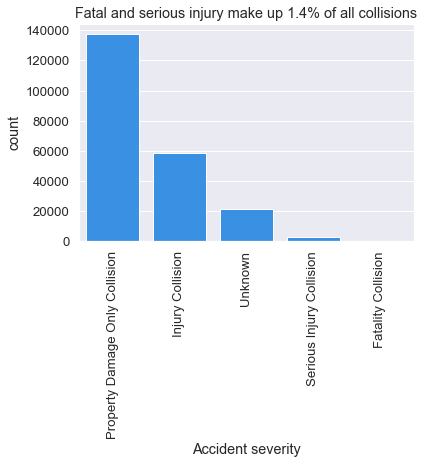

In [78]:
sb.set(font_scale = 1.2)
sb.barplot(x = "severitydesc", y = "count", color = "dodgerblue", \
           data = collision_severity_dist_df)
plt.xlabel("Accident severity")
plt.xticks(rotation = 90)
plt.title(label = "Fatal and serious injury make up 1.4% of all collisions")
plt.show()

In [ ]:
#### Plot collision type distribution

In [80]:
collision_colltype_dist_df = collision_df.groupby(["collisiontype"]).size().reset_index(name = "count")
collision_colltype_dist_df = collision_colltype_dist_df.sort_values("count", ascending = False)

In [92]:
collision_colltype_dist_df

,collisiontype,count
5,Parked Car,48455
0,Angles,35469
7,Rear Ended,34624
4,Other,24528
9,Sideswipe,18855
3,Left Turn,14082
6,Pedestrian,7654
1,Cycles,5911
8,Right Turn,3008
2,Head On,2181


In [93]:
(7654+5911)/194767

0.06964732218496973

In [94]:
collision_type_perc = collision_colltype_dist_df[(collision_colltype_dist_df["collisiontype"] == "Pedestrian") | \
                                             (collision_colltype_dist_df["collisiontype"] == "Cycles")]["count"].sum()/collision_addr_dist_df["count"].sum()
print("Pdestrians and cyclists are {}% of accidents" .format(np.round(collision_type_perc * 100, 1)))

Pdestrians and cyclists are 6.2% of accidents


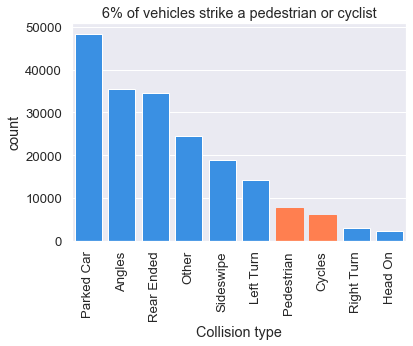

In [101]:
sb.set(font_scale = 1.2)
ax = sb.barplot(x = "collisiontype", y = "count", color = "dodgerblue", \
           data = collision_colltype_dist_df)
ax.patches[6].set_color("coral")
ax.patches[7].set_color("coral")
plt.xlabel("Collision type")
plt.xticks(rotation = 90)
plt.title(label = "6% of vehicles strike a pedestrian or cyclist")
plt.show()

#### Plot distribution of under the influence (underinfl)

Takes values of Y, N, 0 and 1. Replace Y with 1 and N with 0

In [241]:
collision_df["underinfl"].replace("Y", "1", inplace = True)
collision_df["underinfl"].replace("N", "0", inplace = True)
collision_df["underinfl"] = collision_df["underinfl"].astype(int)

In [242]:
collision_underinfl_df = collision_df.groupby(["underinfl"]).size().reset_index(name = "count")

In [243]:
underinfl_perc = collision_underinfl_df[collision_underinfl_df["underinfl"] == 1]["count"].sum()/collision_underinfl_df["count"].sum() 
print("{}% of drivers are under the influence of drugs or alcohol" .format(np.round(underinfl_perc * 100, 1)))

5.0% of drivers are under the influence of drugs or alcohol


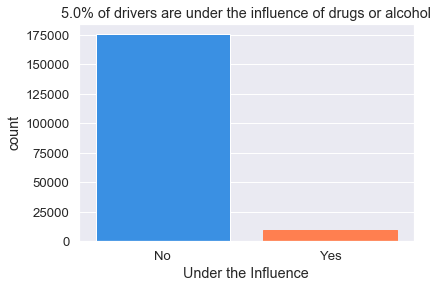

In [245]:
sb.set(font_scale = 1.2)
ax = sb.barplot(x = "underinfl", y = "count", color = "dodgerblue", \
           data = collision_underinfl_df)
ax.set_xticklabels(["No", "Yes"])
ax.patches[1].set_color("coral")
plt.xlabel("Under the Influence")
plt.title(label = "5.0% of drivers are under the influence of drugs or alcohol")
plt.show()

#### Plot distribution of outdoor conditions

In [264]:
def conditions(conditions_df, xlabel, ylabel, axs, ax):
    sb.barplot(x = xlabel, y = ylabel, color = "dodgerblue", dodge = False, \
                data = conditions_df, ax = axs[ax])
    axs[ax].set_xlabel(xlabel)
    axs[ax].set_ylabel(ylabel)
    axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation = 90)
   # plt.show()
    
    return
    

In [266]:
weather_df = collision_df.groupby(["weather"]).size().reset_index(name = "count").sort_values("count", ascending = False)
road_df = collision_df.groupby(["roadcond"]).size().reset_index(name = "count").sort_values("count", ascending = False)
light_df = collision_df.groupby(["lightcond"]).size().reset_index(name = "count").sort_values("count", ascending = False)

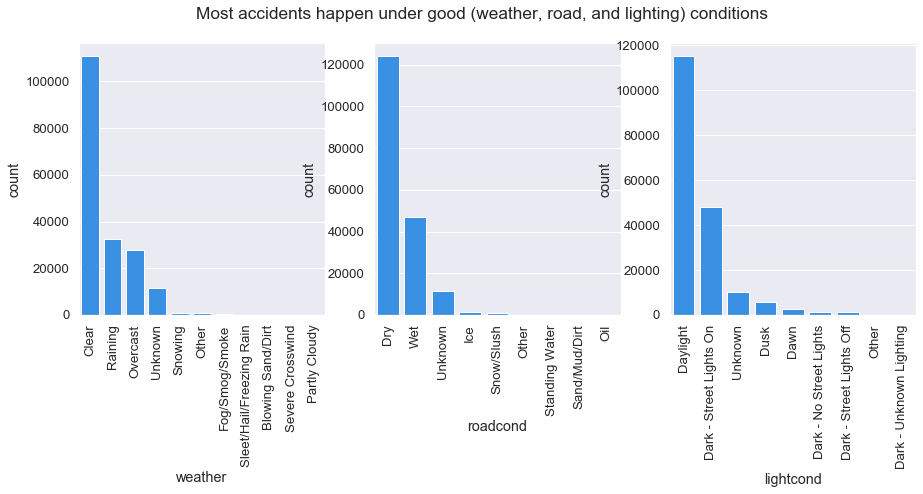

In [274]:
fig, axs = plt.subplots(ncols = 3, figsize = (15, 5))
conditions(weather_df, "weather", "count", axs, 0)
conditions(road_df, "roadcond", "count", axs, 1)
conditions(light_df, "lightcond", "count", axs, 2)
fig.suptitle("Most accidents happen under good (weather, road, and lighting) conditions ")
plt.show()

## Plot bivariate graphs

#### Plot junction type by accident severity

Use junctiontype instead of addrtype. It gives a clearer picture about the effect of intersections on accidents

In [287]:
collision_addr_severity_df = collision_df.groupby(["junctiontype", "severitydesc"]).size().reset_index(name = "count")

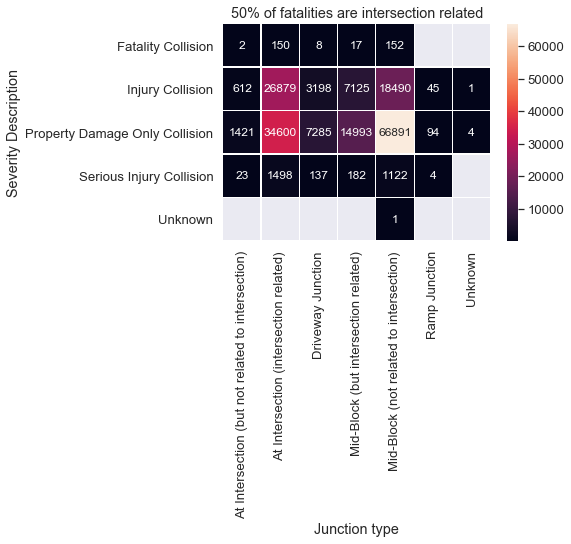

In [300]:
collision_addr_severity_pt = collision_addr_severity_df.pivot("severitydesc", \
                                                              "junctiontype", \
                                                              "count")

font = {"size": "12"}
plt.figure()
plt.rc("font", **font)
sb.heatmap(collision_addr_severity_pt, annot = True, fmt = "g", linewidth = 0.2, linecolor = "white" )
plt.ylabel("Severity Description")
plt.xlabel("Junction type")
plt.title(label = "50% of fatalities are intersection related")
plt.show()

#### Plot  accident severity by collision type

In [274]:
collision_type_df = collision_df.groupby(["collisiontype", "severitydesc"]).size().reset_index(name = "count")

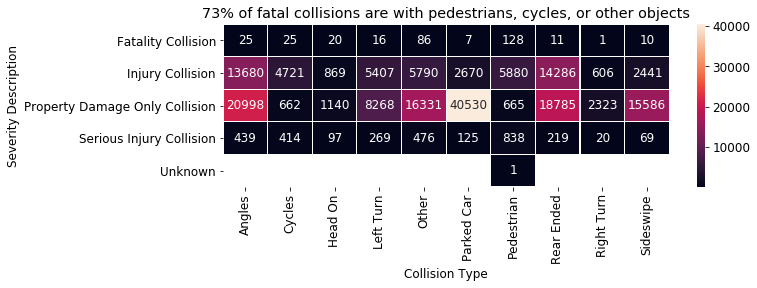

In [305]:
collision_type_pt = collision_type_df.pivot("severitydesc", \
                                                                        "collisiontype", \
                                                                        "count")

font = {"size": "12"}
#plt.figure()
fig, ax = plt.subplots(figsize = (10, 3))
plt.rc("font", **font)
sb.heatmap(collision_type_pt, annot = True, fmt = "g", linewidth = 0.2, \
                linecolor = "white", ax = ax)
plt.ylabel("Severity Description")
plt.xlabel("Collision Type")
#ax.set_xticklabels(["No", "Yes"])
plt.title(label = "73% of fatal collisions are with pedestrians, cycles, or other objects")
plt.show()

#### Plot collision type where drivers were speeding

In [298]:
collision_type_speed_df = collision_df.groupby(["collisiontype", "speeding", "severitydesc"]).size().reset_index(name = "count")

In [299]:
collision_type_speed_df = collision_type_speed_df[collision_type_speed_df["speeding"] == 1]

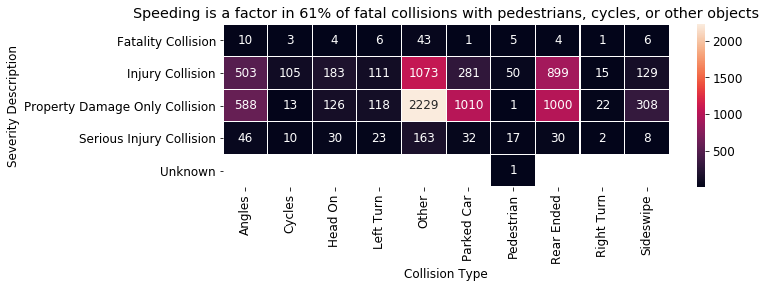

In [306]:
collision_type_speed_pt = collision_type_speed_df.pivot("severitydesc", \
                                                                        "collisiontype", \
                                                                        "count")

font = {"size": "12"}
#plt.figure()
fig, ax = plt.subplots(figsize = (10, 3))
plt.rc("font", **font)
sb.heatmap(collision_type_speed_pt, annot = True, fmt = "g", linewidth = 0.2, \
                linecolor = "white", ax = ax)
plt.ylabel("Severity Description")
plt.xlabel("Collision Type")
#ax.set_xticklabels(["No", "Yes"])
plt.title(label = "Speeding is a factor in 61% of fatal collisions with pedestrians, cycles, or other objects")
plt.show()

#### Plot  accident severity by under the influence

In [291]:
collision_underinfl_severity_df = collision_df.groupby(["underinfl", "severitydesc"]).size().reset_index(name = "count")

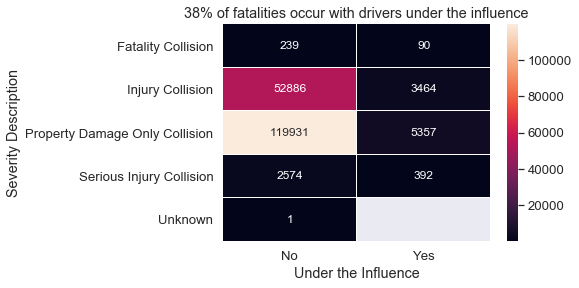

In [299]:
collision_underinfl_severity_pt = collision_underinfl_severity_df.pivot("severitydesc", \
                                                                        "underinfl", \
                                                                        "count")

font = {"size": "12"}
plt.figure()
plt.rc("font", **font)
ax = sb.heatmap(collision_underinfl_severity_pt, annot = True, fmt = "g", linewidth = 0.2, linecolor = "white" )
plt.ylabel("Severity Description")
plt.xlabel("Under the Influence")
ax.set_xticklabels(["No", "Yes"])
plt.title(label = "38% of fatalities occur with drivers under the influence")
plt.show()

#### Plot accident severity by weather, road and lighting conditions

In [302]:
weather_severity_df = collision_df.groupby(["weather", "severitydesc"]).size().reset_index(name = "count").sort_values("count", ascending = False)
road_severity_df = collision_df.groupby(["roadcond", "severitydesc"]).size().reset_index(name = "count").sort_values("count", ascending = False)
light_severity_df = collision_df.groupby(["lightcond", "severitydesc"]).size().reset_index(name = "count").sort_values("count", ascending = False)

In [337]:
def conditions_severity(conditions_df2, xlabel, ylabel, values, xlabelnew):
    conditions_pt = conditions_df2.pivot(ylabel, xlabel, values)

    font = {"size": "10"}
    plt.figure()
    plt.rc("font", **font)
    ax = sb.heatmap(conditions_pt, annot = True, fmt = "g", linewidth = 0.2, linecolor = "white" )
    plt.ylabel("Severity Description")
    plt.xlabel(xlabelnew)
   # ax.set_xticklabels(["No", "Yes"])
   # plt.title(label = "38% of fatalities occur with drivers under the influence")
   # plt.show()
    
    return ax
    

<Figure size 1080x360 with 0 Axes>

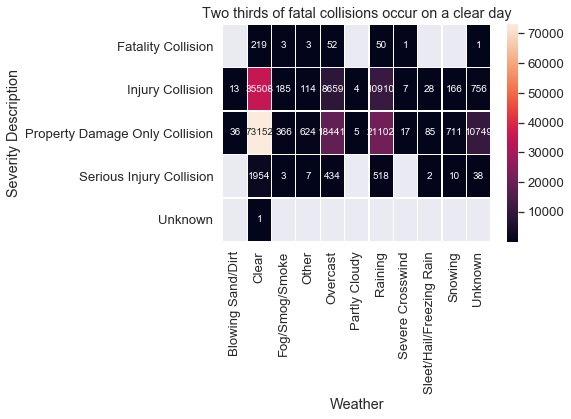

In [338]:
plt.figure(figsize = (15, 5))
ax = conditions_severity(weather_severity_df, "weather", "severitydesc", "count", "Weather")
plt.title(label = "Two thirds of fatal collisions occur on a clear day")
plt.show()

<Figure size 1080x360 with 0 Axes>

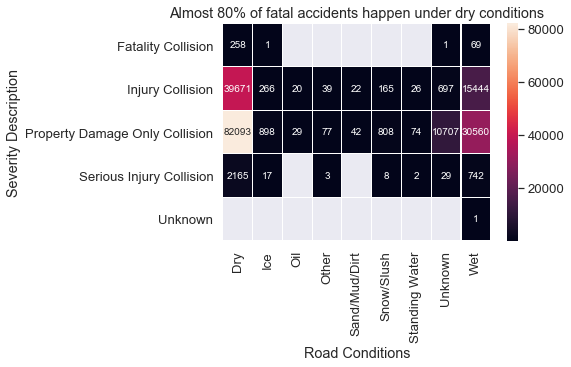

In [339]:
plt.figure(figsize = (15, 5))
ax = conditions_severity(road_severity_df, "roadcond", "severitydesc", "count", \
                    "Road Conditions")
plt.title(label = "Almost 80% of fatal accidents happen under dry conditions")
plt.show()

<Figure size 1080x360 with 0 Axes>

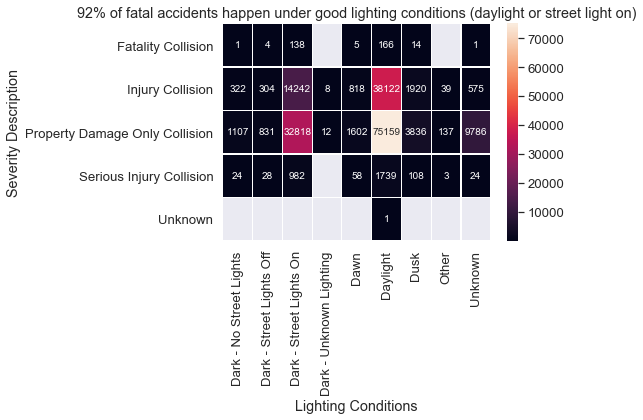

In [340]:
plt.figure(figsize = (15, 5))
ax = conditions_severity(light_severity_df, "lightcond", "severitydesc", "count", \
                    "Lighting Conditions")
plt.title(label = "92% of fatal accidents happen under good lighting conditions (daylight or street light on)")
plt.show()

#### Plot accident severity by inattention

In [335]:
inattention_severity_df = collision_df.groupby(["inattentionind", "severitydesc"]).size().reset_index(name = "count")

<Figure size 1080x360 with 0 Axes>

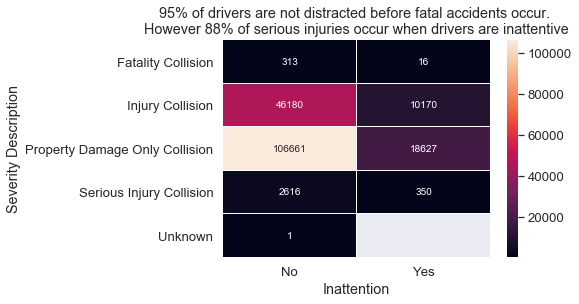

In [347]:
plt.figure(figsize = (15, 5))
ax = conditions_severity(inattention_severity_df, "inattentionind", "severitydesc", "count", \
                    "Inattention")
plt.title(label = "95% of drivers are not distracted before fatal accidents occur. \nHowever 88% of serious injuries occur when drivers are inattentive")
ax.set_xticklabels(["No", "Yes"])
plt.show()

Data appears counter-intuitive. It should be that drivers are not paying attention when fatal accidents occur.

Fatal accidents are 313 when drivers are paying attention vs. 16 when they are not.
The only explanation is that 0 = Yes, and 1 = No. This is somewaht backwards as the reverse should be true.

## Plot fatal collisions on a map

#### Import Seattle shape file

In [235]:
seattle = gpd.read_file("../data/external/Street_Network_Database__SND/Street_Network_Database__SND_.shp")

In [236]:
seattle.head(1)

,OBJECTID,F_INTR_ID,T_INTR_ID,SND_ID,SND_FEACOD,CITYCODE,STNAME_ID,ST_CODE,ARTERIAL_C,SEGMENT_TY,...,R_CITY,R_STATE,R_ZIP,SNDSEG_UPD,COMPKEY,COMPTYPE,UNITID,UNITID2,SHAPE_Leng,geometry
0,1,17740,17791,33478,5,1,566,0,1,1,...,SEATTLE,WA,98108,2007-04-22,8460,68,04805,0820,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."


#### Plot map of seattle

In [237]:
crs = {"init": "epsg:4326"}

In [238]:
geometry = [Point(xy) for xy in zip(collision_df["long"], collision_df["lat"])]

In [243]:
geo_collision_df = gpd.GeoDataFrame(collision_df, crs = crs, geometry = geometry)

In [244]:
geo_collision_df = geo_collision_df[geo_collision_df["severitycode"] == "3"]

In [226]:
#geo_collision_df["addrtype"].str.match("Block") == True
#geo_collision_df["addrtype"] == "Intersection"
collision_df[collision_df["addrtype"] == "Intersection"]

,Unnamed: 0,long,lat,status,addrtype,severitycode,severitydesc,collisiontype,personcount,pedcount,...,hitparkedcar,datetime,year,month,week,dayofweek,hour,minute,weekend,geometry
0,0,-122.386772,47.564720,Matched,Intersection,0,Injury Collision,Pedestrian,2,1,...,0,2019-11-20 10:25:00,2019,11,47,2,10,25,0,POINT (-122.38677 47.56472)
1,1,-122.341806,47.686934,Matched,Intersection,0,Injury Collision,Angles,4,0,...,0,2019-11-18 17:01:00,2019,11,47,0,17,1,0,POINT (-122.34181 47.68693)
3,3,-122.300758,47.683047,Matched,Intersection,0,Property Damage Only Collision,Left Turn,2,0,...,0,2004-06-08 00:00:00,2004,6,24,1,0,0,0,POINT (-122.30076 47.68305)
5,7,-122.330904,47.558650,Matched,Intersection,0,Property Damage Only Collision,Other,1,0,...,0,2013-03-28 14:55:00,2013,3,13,3,14,55,0,POINT (-122.33090 47.55865)
8,10,-122.319539,47.619917,Matched,Intersection,0,Property Damage Only Collision,Angles,2,0,...,0,2006-12-27 12:28:00,2006,12,52,2,12,28,0,POINT (-122.31954 47.61992)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184919,221248,-122.338314,47.614391,Matched,Intersection,0,Property Damage Only Collision,Angles,2,0,...,0,2019-04-27 15:58:00,2019,4,17,5,15,58,1,POINT (-122.33831 47.61439)
184921,221252,-122.376188,47.565039,Matched,Intersection,0,Property Damage Only Collision,Other,1,0,...,0,2019-06-16 05:15:00,2019,6,24,6,5,15,1,POINT (-122.37619 47.56504)
184922,221253,-122.334191,47.598292,Matched,Intersection,0,Property Damage Only Collision,Angles,2,0,...,0,2019-06-12 19:23:00,2019,6,24,2,19,23,0,POINT (-122.33419 47.59829)
184925,221256,-122.316335,47.664928,Matched,Intersection,0,Property Damage Only Collision,Angles,2,0,...,0,2019-05-23 19:19:00,2019,5,21,3,19,19,0,POINT (-122.31633 47.66493)


#### Plot map of fatal collisions by addrtype (junction)

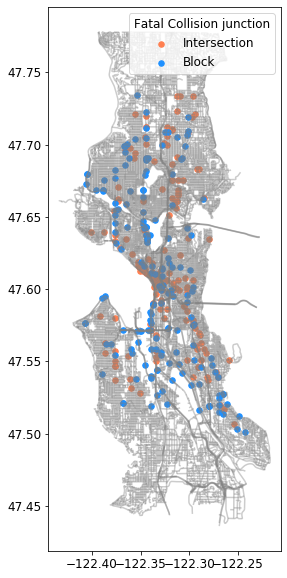

In [289]:
fig, ax = plt.subplots(figsize = (10, 10))
seattle.plot(ax = ax, alpha = 0.4, color = "grey")
geo_collision_df[geo_collision_df["addrtype"].str.match("Intersection")].plot(ax = ax, \
                                                               markersize = 30, \
                                                               color = "coral", marker = "o", \
                                                               label = "Intersection")
geo_collision_df[geo_collision_df["addrtype"].str.match("Block")].plot(ax = ax, \
                                                               markersize = 30, \
                                                               color = "dodgerblue", marker = "o", \
                                                               label = "Block")

plt.legend(title = "Fatal Collision junction")

#### Plot map of fatal colisions of drivers under the influence

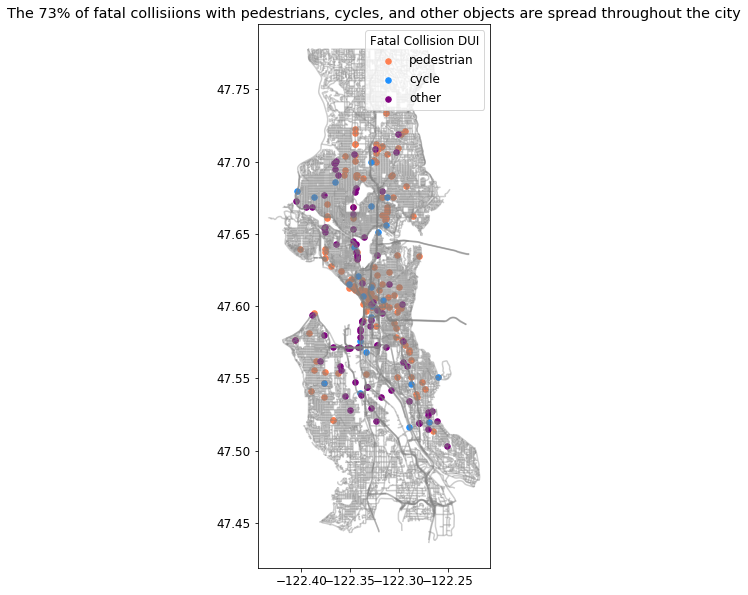

In [297]:
fig, ax = plt.subplots(1, figsize = (10, 10))
seattle.plot(ax = ax, alpha = 0.4, color = "grey")
geo_collision_df[geo_collision_df["collisiontype"] == "Pedestrian"].plot(ax = ax, \
                                                               markersize = 30, \
                                                               color = "coral", marker = "o", \
                                                               label = "pedestrian")
geo_collision_df[geo_collision_df["collisiontype"] == "Cycles"].plot(ax = ax, \
                                                               markersize = 30, \
                                                               color = "dodgerblue", marker = "o", \
                                                               label = "cycle")
geo_collision_df[geo_collision_df["collisiontype"] == "Other"].plot(ax = ax, \
                                                               markersize = 30, \
                                                               color = "purple", marker = "o", \
                                                               label = "other")

plt.legend(title = "Fatal Collision DUI")
plt.title(label = "The 73% of fatal collisiions with pedestrians, cycles, and other objects are spread throughout the city")
plt.show()

## Clean 3 remaining columns - seglanekey, crosswalkkey, and hitparkedcar

In [378]:
collision_df["seglanekey"] = np.where(collision_df["seglanekey"] == 0, 0, 1)
collision_df["crosswalkkey"] = np.where(collision_df["crosswalkkey"] == 0, 0, 1)
collision_df["hitparkedcar"] = np.where(collision_df["hitparkedcar"] == "Y", "1", "0")
collision_df["hitparkedcar"] = collision_df["hitparkedcar"].astype(int)

## Add timeseries columns (date and time)

In [360]:
collision_df["incdttm"] = collision["incdttm"]

In [362]:
collision_df["datetime"] = pd.to_datetime(collision_df["incdttm"], errors = "coerce")

In [363]:
collision_df["year"] = collision_df["datetime"].dt.year
collision_df["month"] = collision_df["datetime"].dt.month
#donations_df["quarter"] = donations_df["datetime"].dt.quarter
collision_df["week"] = collision_df["datetime"].dt.week
collision_df["dayofweek"] = collision_df["datetime"].dt.dayofweek
collision_df["hour"] = collision_df["datetime"].dt.hour
collision_df["minute"] = collision_df["datetime"].dt.minute
#donations_df["Weekdayname"] = donations_df["Gift_Date2"].dt.day_name

In [372]:
collision_df["weekend"] = np.where(collision_df["dayofweek"] < 5, 0, 1)

#### Placeholder to save collision_df file

In [410]:
collision_df.to_csv("../data/interim/collision_df.csv")

###################################################################################

#### Read collision_df.csv file

In [230]:
collision_df = pd.read_csv("../data/interim/collision_df.csv")

Severirty code = 1 accounts for < 2% of labels. The problem is still anomaly detection. Use SVM or neural networks to build model

SVM:
    Use standard, weighted, and one-class SVM to compare results

In [6]:
col2 = [#'status', \
       # 'severitydesc', 
        'collisiontype', \
       'incdttm', 'junctiontype', \
       'sdot_coldesc', 'weather', 'roadcond',
       'lightcond' #, \ 
       # 'seglanekey', 'crosswalkkey', 'hitparkedcar', 'month', 'dayofweek', \
       # 'weekend', 'hour'
       ]

## Encode categorical variables into numerical

#### Encode variables

In [7]:
collision_df2 = collision_df #.sample(n = collision_df.shape[0], axis = 0, \
                                   # random_state = 20201007)
collision_df3 = collision_df2[col2]

In [8]:
def encode_strings(encodestr_df):
    labels_lst = []
    le = LabelEncoder()
   # encodestr_df = encodestr_df.drop(columns = ["gift amount"])
    #print(encodestr_df.head()) 
    
    for col in encodestr_df.columns:
        le_array = le.fit_transform(encodestr_df[col])
        labels_lst.append(le_array)
        labels_np = np.transpose(np.array(labels_lst))
     
    labels_df = pd.DataFrame(labels_np, columns = encodestr_df.columns).reset_index()
    labels_df = labels_df.reset_index()
    
    return labels_df
    

In [9]:
collision_enc_df = encode_strings(collision_df3)

In [10]:
othercol_df = collision_df2[['long', 'lat', 'severitycode', 'personcount', \
       'pedcount', 'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries',
       'fatalities', 'inattentionind', 'underinfl', 'speeding', \
        'seglanekey', 'crosswalkkey', 'hitparkedcar', 'month', 'dayofweek', \
        'weekend', 'hour']].reset_index()

In [11]:
collision_enc_df = pd.concat([collision_enc_df, othercol_df], axis = 1)

In [12]:
collision_enc_df.drop(columns = ["level_0", "index"], inplace = True)

#### Convert output variable severity code into two integer values 0 and 1

In [3]:
 collision_df["severitycode"] = np.where((collision_df["severitycode"].str.match("3") | \
              collision_df["severitycode"].str.match("2b")), "1", "0")
collision_df["severitycode"] = collision_df["severitycode"].astype(int)

In [4]:
Counter(collision_df["severitycode"])

Counter({0: 181639, 1: 3295})

## Create a baseline model

Assume a F1-score where predict is always true
f1_score = 2r/(r + 1)

In [113]:
(collision_df["severitycode"] == 1).sum()

3295

In [114]:
precision = (collision_df["severitycode"] == 1).sum()/collision_df["severitycode"].count()

In [116]:
f1_score_baseline = 2 * precision/float(precision + 1)

In [117]:
print("Baseline f1-score = {}" .format(f1_score_baseline))

Baseline f1-score = 0.03501054566512067


## Create a training and test set

In [62]:
X = collision_enc_df.drop(columns = "severitycode", axis = 1)
y = collision_enc_df["severitycode"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, \
                                                    random_state = 20201003)

## Build a Support Vector Machine (SVM) model

In [118]:
svc_model = SVC(gamma = "auto")

In [164]:
%%time
svc_model.fit(X_train, y_train)

Wall time: 2h 28min 42s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Predict labels - modified severity code

In [165]:
%%time
y_predict = svc_model.predict(X_test)

Wall time: 16min 56s


In [166]:
f1_score(y_test, y_predict, average = "binary")

0.0

In [167]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label = 1)
auc(fpr, tpr)

0.4999908243411877

F1-score = 0
Area under the curve (AUC) = 0.5
SVM classifier score = 0.98

The time taken to run the svm model using all 27 features takes 2.5 hours.
Reduce the features using principal components analysis (PCA). This will likely improve the time and model performance.

## Reduce dimensions using PCA

#### Fit scaler on training set and apply transform to both training and test set 

In [135]:
get_scaler = StandardScaler()

In [136]:
get_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [137]:
X_train_scale = get_scaler.transform(X_train)
X_test_scale = get_scaler.transform(X_test)

#### Reduce dimensions using PCA

In [138]:
pca = PCA(0.95)

In [139]:
pca.fit(X_train_scale)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [140]:
X_train_pca = pca.transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

## Build a Support Vector Machine (SVM) model

In [142]:
svc_pca_model = SVC(gamma = "auto")

In [143]:
svc_pca_model.fit(X_train_pca, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Predict labels - modified severity code

In [145]:
y_pca_predict = svc_pca_model.predict(X_test_pca)

In [146]:
f1_score(y_test, y_pca_predict, average = "binary")

0.9979736575481256

In [147]:
fpr, tpr, thresholds = roc_curve(y_test, y_pca_predict, pos_label = 1)
auc(fpr, tpr)

0.9979777553083924

F1-score = 0.998
Area under the curve (AUC) = 0.998
SVM classifier score = 100

The data has imbalance classes where a fatal or serious injury collision account for 2% of the labels (label = 1).
Test anomaly detection  one-class SVM onthe data to compare performance

#### One-class Support Vector Machine

In [150]:
oneclass_model = OneClassSVM(gamma = "auto", nu = 0.018)

In [157]:
%%time
oneclass_model.fit(X_train_pca)

Wall time: 1min 35s


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.018, shrinking=True, tol=0.001, verbose=False)

In [152]:
y_predict_oneclass = oneclass_model.predict(X_test_pca)

In [153]:
y_predict_oneclass2 = y_predict_oneclass
y_predict_oneclass2 = np.where(y_predict_oneclass2 == -1, 1, 0)
#y_predict_oneclass2[y_predict_oneclass2 == -1] = 1
#y_predict_oneclass2[y_predict_oneclass2 == 1] = 0 

In [154]:
f1_score(y_test, y_predict_oneclass2, average = "binary")

0.3771043771043771

In [158]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict_oneclass2, pos_label = 1)
auc(fpr, tpr)

0.6917753699265659

In [ ]:
F1-score = 0.38
Area under the curve (AUC) = 0.69

Performance of the model degraded when treated as an anomaly detection problem.